<a href="https://colab.research.google.com/github/unknown137-dimas/CapstoneProject/blob/master/ML/dataset_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt

# Setup

In [ ]:
TRAIN_FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/train_dataset.csv'
TEST_FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/test_dataset.csv'
SAVED_FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/savedModel/dataset_model'
TFLITE_FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/savedModel/converted_model.tflite'

# Data Preprocessing

In [ ]:
train_file = pd.read_csv(TRAIN_FILE_PATH)
test_file = pd.read_csv(TEST_FILE_PATH)
labels = ['finance', 'marketing', 'innovation']

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_file.drop('label', axis=1).values, train_file['label'].values)).shuffle(150)
train_dataset = train_dataset.map(lambda x, y: (x, tf.where(tf.equal(labels, y))[0])).batch(50)

test_dataset = tf.data.Dataset.from_tensor_slices((test_file.drop('label', axis=1).values, test_file['label'].values))
test_dataset = test_dataset.map(lambda x, y: (x, tf.where(tf.equal(labels, y))[0])).batch(50)

In [ ]:
# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

# Model Training

In [ ]:
model = tf.keras.Sequential([keras.layers.Dense(units=15, activation='relu'),
                             keras.layers.Dense(units=3, activation='softmax')
                            ])

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 15)                240       
                                                                 
 dense_5 (Dense)             (None, 3)                 48        
                                                                 
Total params: 288
Trainable params: 288
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(train_dataset, epochs=500, validation_data=test_dataset)

Epoch 1/500
20/20 [==============================] - 1s 11ms/step - loss: 1.1891 - accuracy: 0.4200 - val_loss: 1.1013 - val_accuracy: 0.4300
Epoch 2/500
20/20 [==============================] - 0s 5ms/step - loss: 1.0419 - accuracy: 0.4740 - val_loss: 1.0060 - val_accuracy: 0.4700
Epoch 3/500
20/20 [==============================] - 0s 6ms/step - loss: 0.9635 - accuracy: 0.5240 - val_loss: 0.9358 - val_accuracy: 0.5100
Epoch 4/500
20/20 [==============================] - 0s 5ms/step - loss: 0.8935 - accuracy: 0.5690 - val_loss: 0.8732 - val_accuracy: 0.5700
Epoch 5/500
20/20 [==============================] - 0s 5ms/step - loss: 0.8331 - accuracy: 0.6300 - val_loss: 0.8164 - val_accuracy: 0.6400
Epoch 6/500
20/20 [==============================] - 0s 5ms/step - loss: 0.7783 - accuracy: 0.6720 - val_loss: 0.7636 - val_accuracy: 0.7300
Epoch 7/500
20/20 [==============================] - 0s 5ms/step - loss: 0.7282 - accuracy: 0.7170 - val_loss: 0.7166 - val_accuracy: 0.7800
Epoch 8/500


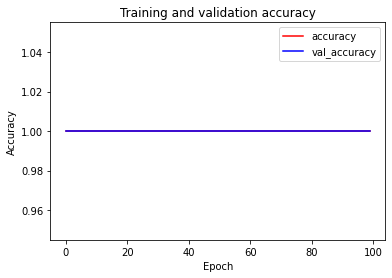

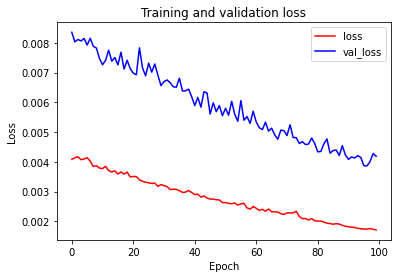

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training data
# sets for the last 100 training epoch
#-----------------------------------------------------------

acc=history.history['accuracy'][-100:]
loss=history.history['loss'][-100:]
val_acc=history.history['val_accuracy'][-100:]
val_loss=history.history['val_loss'][-100:]

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss,'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)

2/2 [==============================] - 0s 12ms/step - loss: 0.0032 - accuracy: 1.0000


# Prediction

In [ ]:
# Make a prediction
#['finance', 'marketing', 'innovation']
output_array = model.predict([[1,4,4,1,1,1,2,2,4,1,2,3,3,1,4]])
print(output_array, labels[np.argmax(output_array)])

[[0. 1. 0.]] marketing


# Save Model

In [ ]:
!mkdir -p '/content/drive/MyDrive/Colab Notebooks/Capstone Project/savedModel'
model.save(SAVED_FILE_PATH)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Capstone Project/savedModel/dataset_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Capstone Project/savedModel/dataset_model/assets


# Test Saved Model

In [ ]:
saved_model = tf.keras.models.load_model(SAVED_FILE_PATH)

# Make a prediction
#['finance', 'marketing', 'innovation']
print(saved_model.predict([[2,1,3,3,3,1,2,2,5,5,5,5,2,4,2]]))

[[1. 0. 0.]]


# Convert to TFLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_FILE_PATH)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [ ]:
with open(TFLITE_FILE_PATH, "wb") as f:
    f.write(tflite_model)

# Test Converted Model

In [ ]:
interpreter = tf.lite.Interpreter(TFLITE_FILE_PATH)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
test = [[4,1,1,4,5,4,5,3,3,3,1,1,3,2,2]]
interpreter.set_tensor(input_index, test)
interpreter.invoke()
print(interpreter.get_tensor(output_index))

[[0. 0. 1.]]
